In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

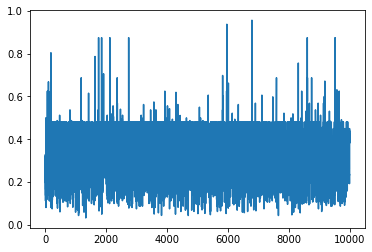

In [ ]:
training_set = pd.read_csv('/content/data(1).csv')


training_set = training_set.iloc[:,1:2].values


plt.plot(training_set, label = 'load prediction data')
plt.show()

In [ ]:
#no of time steps  to predict the next step
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
num_epochs = 2000 #no of passes/times the algorithm is gonna run on the entire training dataset
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.12793
Epoch: 100, loss: 0.01613
Epoch: 200, loss: 0.01136
Epoch: 300, loss: 0.01028
Epoch: 400, loss: 0.01020
Epoch: 500, loss: 0.01017
Epoch: 600, loss: 0.01015
Epoch: 700, loss: 0.01013
Epoch: 800, loss: 0.01011
Epoch: 900, loss: 0.01010
Epoch: 1000, loss: 0.01010
Epoch: 1100, loss: 0.01009
Epoch: 1200, loss: 0.01008
Epoch: 1300, loss: 0.01008
Epoch: 1400, loss: 0.01007
Epoch: 1500, loss: 0.01007
Epoch: 1600, loss: 0.01006
Epoch: 1700, loss: 0.01006
Epoch: 1800, loss: 0.01005
Epoch: 1900, loss: 0.01004


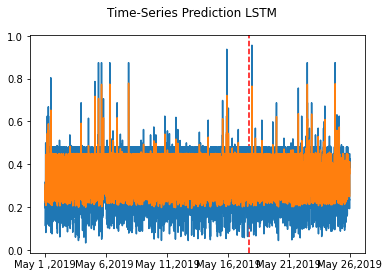

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
x_ticks = [2, 2000, 4000, 6000, 8000,10000]

#specify x-axis labels
x_labels = ['May 1 ,2019', 'May 6,2019 ', 'May 11,2019', 'May 16,2019', 'May 21,2019','May 26,2019'] 

#add x-axis values to plot
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.suptitle('Time-Series Prediction LSTM')
plt.show()

In [ ]:
d1 = pd.DataFrame(data_predict, columns = ['Predicted_CPU_Request'])
print(d1)

      Predicted_CPU_Request
0                  0.264463
1                  0.250643
2                  0.267706
3                  0.251374
4                  0.307951
...                     ...
9990               0.248937
9991               0.361583
9992               0.412482
9993               0.329143
9994               0.356746

[9995 rows x 1 columns]


In [ ]:
d2 = pd.DataFrame(dataY_plot, columns = ['Existing_CPU_Request'])
print(d2)

      Existing_CPU_Request
0                 0.196928
1                 0.237510
2                 0.197808
3                 0.318098
4                 0.112460
...                    ...
9990              0.412480
9991              0.449960
9992              0.318766
9993              0.381855
9994              0.425040

[9995 rows x 1 columns]


In [ ]:
results = pd.concat([d1, d2], axis=1, join='inner')
display(results)

,Predicted_CPU_Request,Existing_CPU_Request
0,0.264463,0.196928
1,0.250643,0.237510
2,0.267706,0.197808
3,0.251374,0.318098
4,0.307951,0.112460
...,...,...
9990,0.248937,0.412480
9991,0.361583,0.449960
9992,0.412482,0.318766
9993,0.329143,0.381855


In [ ]:
results['Val_Diff'] = results['Predicted_CPU_Request'] - results['Existing_CPU_Request']

In [ ]:
display(results)

,Predicted_CPU_Request,Existing_CPU_Request,Val_Diff
0,0.264463,0.196928,0.067535
1,0.250643,0.237510,0.013133
2,0.267706,0.197808,0.069898
3,0.251374,0.318098,-0.066724
4,0.307951,0.112460,0.195491
...,...,...,...
9990,0.248937,0.412480,-0.163543
9991,0.361583,0.449960,-0.088377
9992,0.412482,0.318766,0.093716
9993,0.329143,0.381855,-0.052712


In [ ]:
results.loc[results['Val_Diff'] <= (0.2*results['Existing_CPU_Request']), 'Resource_allocation_required'] = 'No'
results.loc[results['Val_Diff'] >= (0.2*results['Existing_CPU_Request']), 'Resource_allocation_required'] = 'Yes'

In [ ]:
results.head(20)

,Predicted_CPU_Request,Existing_CPU_Request,Val_Diff,Resource_allocation_required
0,0.264463,0.196928,0.067535,Yes
1,0.250643,0.237510,0.013133,No
2,0.267706,0.197808,0.069898,Yes
3,0.251374,0.318098,-0.066724,No
4,0.307951,0.112460,0.195491,Yes
5,0.219451,0.249998,-0.030547,No
6,0.271822,0.218660,0.053162,Yes
7,0.259314,0.137460,0.121854,Yes
8,0.228763,0.268150,-0.039387,No
9,0.279251,0.165567,0.113684,Yes


In [ ]:
#Root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt
print("rMSE")
print(sqrt(mean_squared_error(dataY_plot, data_predict)))

#mean squared error
print("MSE")
print(mean_squared_error(dataY_plot, data_predict))

#r2 score
from sklearn.metrics import r2_score
print("R2 score")

r2_score(dataY_plot, data_predict)
#mean absolute error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(dataY_plot, data_predict)
print('Test MAE: %.3f' % mae)

#mean percentage error
mpe_sum = 0
for i,j in zip(dataY_plot, data_predict):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/data_predict)*100
print('Test MPE')
print(mpe)

#mean absolute percentage error
from sklearn.metrics import mean_absolute_error
mape = mean_absolute_error(dataY_plot, data_predict)*100
print("MAPE")
print(mape)

#Normalized root mean square deviation
from statistics import *
RMSE=sqrt(mean_squared_error(dataY_plot, data_predict))
NRMSE = RMSE/mean (data_predict.flatten())
print("NRMSE")
print(NRMSE)

rMSE
0.09300355980838344
MSE
0.008649662
R2 score
Test MAE: 0.072
Test MPE
[[-490371.72]
 [-517410.84]
 [-484432.72]
 ...
 [-314402.06]
 [-394009.1 ]
 [-363523.28]]
MAPE
7.189677655696869
NRMSE
0.27008384473746966
